# **Task 3: Customer Segmentation / Clustering**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

## **Preparing Dataset**

In [4]:
Customer_df = pd.read_csv("C:/Users/User/Desktop/data science/Zeotap Assignment/data/Customers.csv")
Transactions_df = pd.read_csv("C:/Users/User/Desktop/data science/Zeotap Assignment/data/Transactions.csv")

In [5]:
merged_df = pd.merge(Customer_df, Transactions_df, on="CustomerID", how="inner")

In [7]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       1000 non-null   object 
 1   CustomerName     1000 non-null   object 
 2   Region           1000 non-null   object 
 3   SignupDate       1000 non-null   object 
 4   TransactionID    1000 non-null   object 
 5   ProductID        1000 non-null   object 
 6   TransactionDate  1000 non-null   object 
 7   Quantity         1000 non-null   int64  
 8   TotalValue       1000 non-null   float64
 9   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 78.3+ KB


In [9]:
customer_agg = merged_df.groupby('CustomerID').agg({
    'Quantity': 'sum',       
    'TotalValue': ['sum', 'mean'],  
    'TransactionID': 'count', 
}).reset_index()

customer_agg.columns = ['CustomerID', 'TotalQuantity', 'TotalSpending', 'AvgSpending', 'TransactionCount']

In [10]:
customer_profiles = merged_df[['CustomerID', 'Region', 'SignupDate']].drop_duplicates()
customer_agg = customer_agg.merge(customer_profiles, on='CustomerID', how='left')

In [11]:
customer_agg.head(2)

,CustomerID,TotalQuantity,TotalSpending,AvgSpending,TransactionCount,Region,SignupDate
0,C0001,12,3354.52,670.904,5,South America,2022-07-10
1,C0002,10,1862.74,465.685,4,Asia,2022-02-13


In [12]:
customer_agg['SignupDate'] = pd.to_datetime(customer_agg['SignupDate'])
customer_agg['CustomerTenure'] = (pd.Timestamp('2025-01-01') - customer_agg['SignupDate']).dt.days

In [13]:
customer_agg = pd.get_dummies(customer_agg, columns=['Region'], drop_first=True)

In [14]:
customer_agg = customer_agg.drop(columns=['SignupDate', 'CustomerID'])

In [16]:
customer_agg.head(2)

,TotalQuantity,TotalSpending,AvgSpending,TransactionCount,CustomerTenure,Region_Europe,Region_North America,Region_South America
0,12,3354.52,670.904,5,906,False,False,True
1,10,1862.74,465.685,4,1053,False,False,False


In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_agg)

## **KMeans clustering**

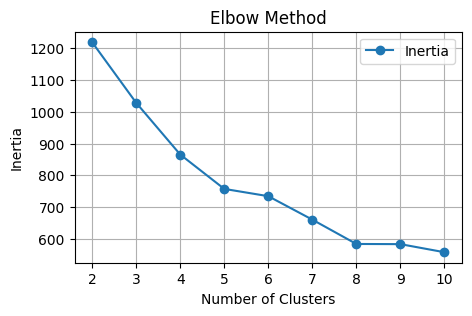

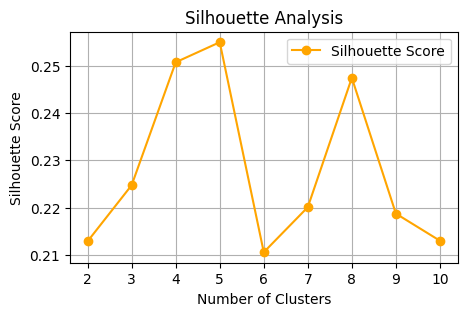

In [21]:
# Determining the optimal number of clusters(Elbow method)
inertia = []
silhouette_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Elbow Method
plt.figure(figsize=(5, 3))
plt.plot(cluster_range, inertia, marker='o', label='Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.legend()
plt.grid()

# Silhouette Scores
plt.figure(figsize=(5, 3))
plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.legend()
plt.grid()

plt.show()

In [37]:
# K-Means with optimal clusters
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_agg['Cluster'] = kmeans.fit_predict(scaled_features)


In [38]:
db_index = davies_bouldin_score(scaled_features, customer_agg['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

silhouette_avg = silhouette_score(scaled_features, customer_agg['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Davies-Bouldin Index: 1.362853563600773
Silhouette Score: 0.2507531504753906


In [44]:
customer_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TotalQuantity         199 non-null    int64  
 1   TotalSpending         199 non-null    float64
 2   AvgSpending           199 non-null    float64
 3   TransactionCount      199 non-null    int64  
 4   CustomerTenure        199 non-null    int64  
 5   Region_Europe         199 non-null    bool   
 6   Region_North America  199 non-null    bool   
 7   Region_South America  199 non-null    bool   
 8   Cluster               199 non-null    int32  
 9   PCA1                  199 non-null    float64
 10  PCA2                  199 non-null    float64
dtypes: bool(3), float64(4), int32(1), int64(3)
memory usage: 12.4 KB


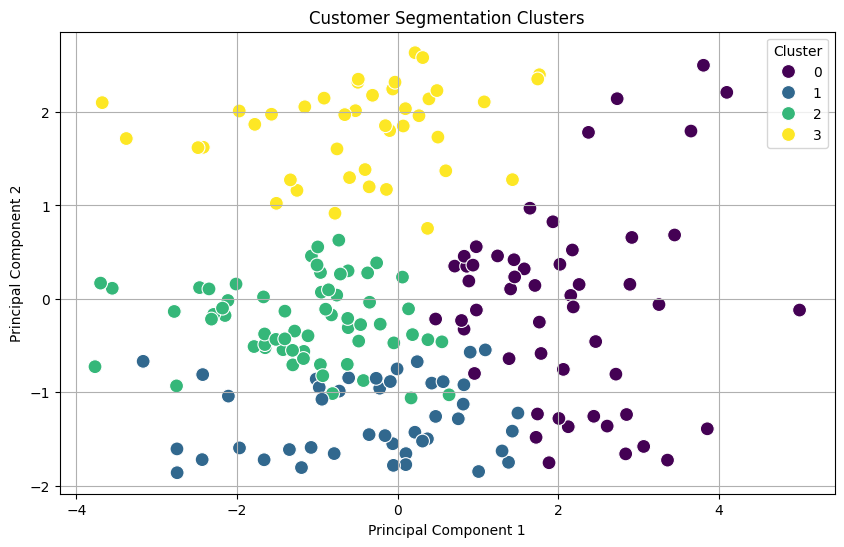

In [52]:
# Visualizing clusters using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)
customer_agg['PCA1'] = reduced_data[:, 0]
customer_agg['PCA2'] = reduced_data[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_agg, palette='viridis', s=100)
plt.title('Customer Segmentation Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

In [53]:
customer_agg.groupby('Cluster').mean()

,TotalQuantity,TotalSpending,AvgSpending,TransactionCount,CustomerTenure,Region_Europe,Region_North America,Region_South America,PCA1,PCA2
Cluster,,,,,,,,,,
0,20.307692,5770.183077,802.496784,7.384615,543.230769,0.269231,0.096154,0.288462,2.104486,-0.077991
1,10.863636,2905.595455,644.069428,4.454545,568.545455,0.000000,0.000000,1.000000,-0.347973,-1.274300
2,8.709677,2316.057097,659.818997,3.612903,573.806452,0.580645,0.000000,0.000000,-1.196270,-0.234442
3,11.292683,2890.348780,630.507093,4.780488,415.975610,0.000000,1.000000,0.000000,-0.486675,1.820979


In [54]:
cluster_summary = customer_agg.groupby('Cluster').agg({
    'TotalSpending': ['mean', 'sum'],
    'TransactionCount': ['mean'],
    'TotalQuantity': ['mean']
}).round(2)

print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
        TotalSpending            TransactionCount TotalQuantity
                 mean        sum             mean          mean
Cluster                                                        
0             5770.18  300049.52             7.38         20.31
1             2905.60  127846.20             4.45         10.86
2             2316.06  143595.54             3.61          8.71
3             2890.35  118504.30             4.78         11.29
